# Cálculo de incertidumbre para modelos de clasificación

## Introducción

En este notebook se van a presentar diferentes datasets con drifts en posiciones conocidas. Para cada dataset se va a mostrar la evolución de la incertidumbre, calculada según diferentes métodos. El objetivo consiste en encontrar una relación entre aumento de incertidumbre y la aparición de drift. 



## Cargar Librerias

In [1]:
!pip install nonconformist


import numpy as np
import pandas as pd
from sklearn import preprocessing
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from nonconformist.cp import IcpClassifier
from nonconformist.nc import ClassifierNc, ClassifierAdapter, MarginErrFunc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


random_state = np.random.RandomState(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Datasets

### Funciones de apoyo

In [2]:
def mergeDataSetsSudden(dataset1, dataset2):
  res = []
  for data in dataset1.values.tolist():
    res.append(data)
  for data in dataset2.values.tolist():
    res.append(data)
  return pd.DataFrame(data=res, columns=dataset1.columns)

def generateClassificationDataSetByLine(count = 100, range_x=[-1000,1000], range_y=[-1000,1000], border=0):
  data = []
  for n in range(count):
    x = random_state.randint(range_x[0], range_x[1], 1)[0]
    y = random_state.randint(range_y[0], range_y[1], 1)[0]
    target = x+y > border
    data.append([n, x,y,target])
  return pd.DataFrame(data, columns=['n', 'x', 'y', 'target'])

def generateClassificationDataSetWithGradualDrift(counts = [1000,1000], drift_length=300, range_x=[-1000,1000], range_y=[-1000,1000], borders=[-100,100]):
  datasets = []
  datasets.append(generateClassificationDataSetByLine(count=int(round(counts[0]-drift_length/2)), range_x=range_x, range_y=range_y, border=borders[0]))
  border_length = abs(borders[1]-borders[0])
  for i in range(drift_length):
    border = i / drift_length * border_length + borders[0]
    datasets.append(generateClassificationDataSetByLine(count=1,range_x=range_x, range_y=range_y, border=border ))
  datasets.append(generateClassificationDataSetByLine(count=int(round(counts[1]-drift_length/2)), range_x=range_x, range_y=range_y, border=borders[1]))
  return reduce(mergeDataSetsSudden, datasets)

def generateClassificationDataSetWithSuddenDrift(counts=[1000,1000], borders = [-100, 100]):
  datasets = []

  for d in zip(counts, borders):
    dataset = generateClassificationDataSetByLine(count=d[0], border=d[1])
    datasets.append(dataset)
  return reduce(mergeDataSetsSudden, datasets)


def normalizeData(dataset):
  return (dataset-dataset.mean())/dataset.std()

def normalizeDataForClassification(dataset):
  df_target = dataset['target']
  dataset = normalizeData(dataset[['x', 'y']])
  dataset['target'] = np.where(df_target, 1, 0)
  dataset['n'] = [n for n in range(len(dataset['target']))]
  
  return dataset


### Dataset 1

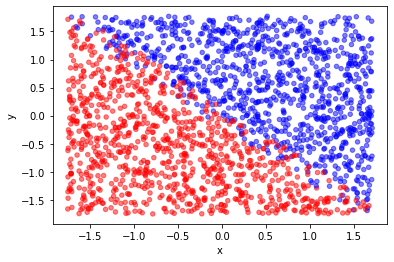

In [3]:
dataset1 =  normalizeDataForClassification(generateClassificationDataSetWithSuddenDrift())
color = np.where(dataset1['target']==1, 'blue', 'red')
dataset1.plot.scatter(x='x', y='y', color=color, alpha=0.5)

### Dataset 2

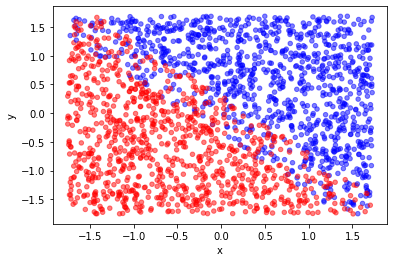

In [4]:
dataset2 =  normalizeDataForClassification(generateClassificationDataSetWithSuddenDrift(borders=[-200, 200]))
color = np.where(dataset2['target']==1, 'blue', 'red')
dataset2.plot.scatter(x='x', y='y', color=color, alpha=0.5)

### Dataset 3

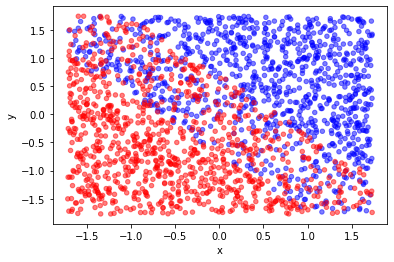

In [5]:
dataset3 =  normalizeDataForClassification(generateClassificationDataSetWithSuddenDrift(borders=[-400, 400]))
color = np.where(dataset3['target']==1, 'blue', 'red')
dataset3.plot.scatter(x='x', y='y', color=color, alpha=0.5)

### Dataset 4

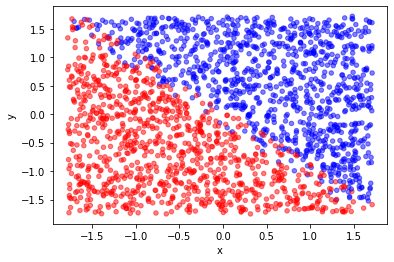

In [6]:
dataset4 =  normalizeDataForClassification(generateClassificationDataSetWithGradualDrift())
color = np.where(dataset4['target']==1, 'blue', 'red')
dataset4.plot.scatter(x='x', y='y', color=color, alpha=0.5)

### Dataset 5

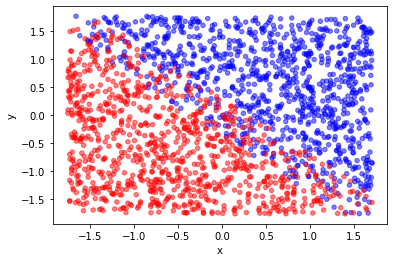

In [7]:
dataset5 =  normalizeDataForClassification(generateClassificationDataSetWithGradualDrift(borders=[-200, 200]))
color = np.where(dataset5['target']==1, 'blue', 'red')
dataset5.plot.scatter(x='x', y='y', color=color, alpha=0.5)

### Dataset 6

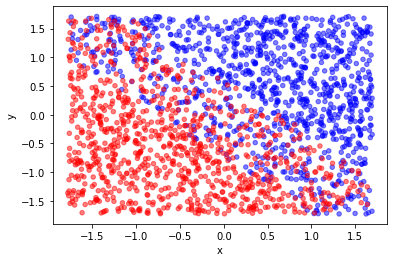

In [8]:
dataset6 =  normalizeDataForClassification(generateClassificationDataSetWithGradualDrift(borders=[-400, 400]))
color = np.where(dataset6['target']==1, 'blue', 'red')
dataset6.plot.scatter(x='x', y='y', color=color, alpha=0.5)

## Métodos de cálculo de incertidumbre para clasificación

### Cálculo de incertidumbre NonConformist

#### Implementación

In [9]:
def getUncertaintyByNCClassification(dataset, model):
  sorted_dataset = dataset.sort_values(by=['n'])
  target = np.array(sorted_dataset['target']).flatten()
  data = np.array(sorted_dataset[['x', 'y']].values.tolist())

  train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=0.7, shuffle=False)
  cal_data, test_data, cal_target, test_target = train_test_split(test_data, test_target, train_size=1/3, shuffle=False)



  res = {'n': sorted_dataset['n'].values.tolist(), 'uncert95': [], 'uncert05':[]}


  if (len(set(train_target)) == 1) or (len(set(cal_target))==1) :
    res['uncert05'] = [0]
    res['uncert95'] = [0]
    return res
  


  # Default nonconformity measure
  nc = ClassifierNc(ClassifierAdapter(model), MarginErrFunc())
  # Inductive conformal classifier
  icp = IcpClassifier(nc)
  # Fit the ICP using the proper training set
  icp.fit(train_data, train_target)
  # Calibrate the ICP using the calibration set
  icp.calibrate(cal_data, cal_target)
  # Desired coverage
  confidence = 0.95
  # Produce predictions for the test set
  prediction = icp.predict(data, significance=None)

  res['uncert05'] = [0 for x in target]
  res['uncert95'] =  np.where(target == True, prediction.T[0], prediction.T[1]) 
  return res

def mergeDict(a,b):
  for key, value in b.items():
    if key in a:
        a[key].extend(value)
    else:
        a[key] = value
  return a

def getUncertaintyByNCOnlineClassifier(dataset, model):
  count = 100
  dataframes = []
  index_to_split = len(dataset) // count
  start = 0
  end = index_to_split
  for split in range(count):
    temporary_df = dataset.iloc[max(0, start-25*index_to_split):end, :]
    dataframes.append(temporary_df)
    start += index_to_split
    end += index_to_split
    

  data = list(map(lambda d: getUncertaintyByNCClassification(d, model), dataframes))
  data = list(map(lambda d: {'uncert95': [np.mean(d['uncert95'])], 'uncert05': [d['uncert05'][-1]], 'n': [d['n'][-1]] }, data))
  single_data = reduce(mergeDict, data)
  df = pd.DataFrame(single_data)
  return df, index_to_split

def showUncertaintyClassifier(data, drifts=[], titles=['', '', '']):
  diff = []
  for u95, u05 in zip(data.get('uncert95'), data.get('uncert05')):
    diff.append(u95-u05)
   
  fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
 
  ax.fill_between(x= data.get('n'), y1=0, y2=diff, label="incertidumbre", alpha=0.5)
  ax.plot(data.get('n'), diff, color="blue")
  ax.legend()
  for drift in drifts:
    ax.axvline(x=drift, color='red')
  ax.set_title(titles[2]+ " Uncertainty")

def showUncertaintyClassifier2(data, drifts=[], titles=['', '', '']):
  diff = []
  for u95, u05 in zip(data.get('uncert95'), data.get('uncert05')):
    diff.append(u95-u05)
   
  fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
  ax[0].fill_between(x = data.get('n'), y1 = data.get('uncert05'), y2 = data.get('uncert95'), alpha=0.5, label="intervalo incertidumbre")
  ax[0].plot(data.get('n'), data.get('uncert05'), color="blue")
  ax[0].plot(data.get('n'), data.get('uncert95'), color="blue")
  ax[0].legend()
  ax[0].set_title(titles[1]+ " Prediction Interval")
  for drift in drifts:
    ax[0].axvline(x=drift, color='red')
  ax[1].fill_between(x= data.get('n'), y1=0, y2=diff, label="incertidumbre", alpha=0.5)
  ax[1].plot(data.get('n'), diff, color="blue")
  ax[1].legend()
  for drift in drifts:
    ax[1].axvline(x=drift, color='red')
  ax[1].set_title(titles[2]+ " Uncertainty")



#### Dataset 1


##### Logistic Regression



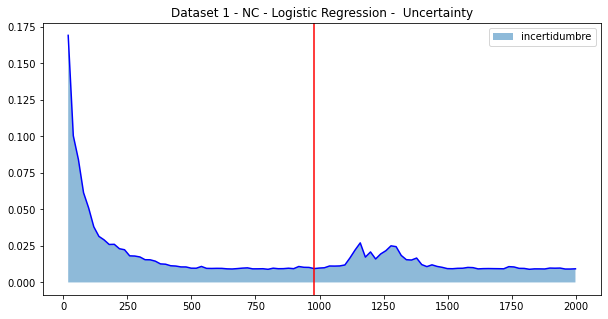

In [10]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset1, model = LogisticRegression())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 1 - NC - Logistic Regression - ', 'Dataset 1 - NC - Logistic Regression - ','Dataset 1 - NC - Logistic Regression - '])
 

##### Decision Tree Classifier

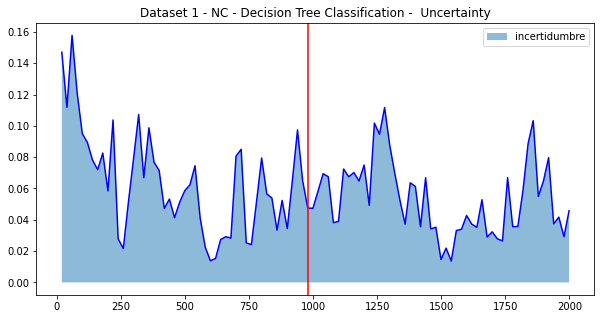

In [11]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset1, model = DecisionTreeClassifier())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 1 - NC - Decision Tree Classification - ', 'Dataset 1 - NC - Decision Tree Classification - ', 'Dataset 1 - NC - Decision Tree Classification - '])
 


#### Dataset 2

##### Logistic Regression


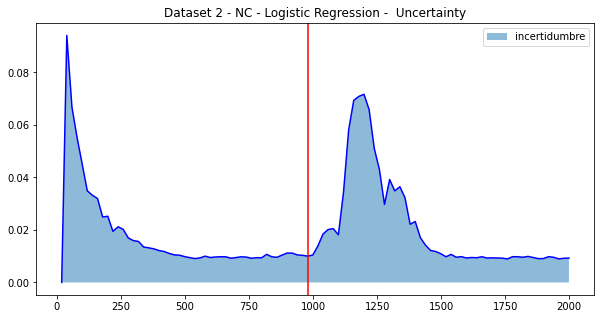

In [12]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset2, model = LogisticRegression())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 2 - NC - Logistic Regression - ', 'Dataset 2 - NC - Logistic Regression - ','Dataset 2 - NC - Logistic Regression - '])
 

##### Decision Tree Classifier

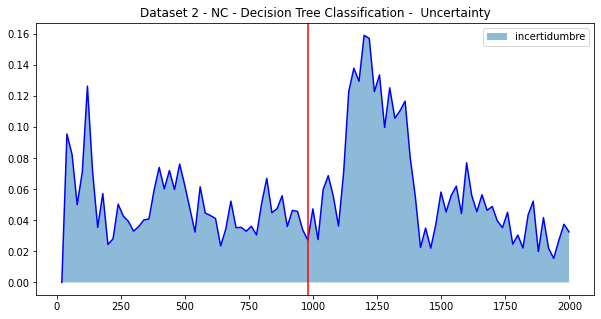

In [13]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset2, model = DecisionTreeClassifier())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 2 - NC - Decision Tree Classification - ', 'Dataset 2 - NC - Decision Tree Classification - ', 'Dataset 2 - NC - Decision Tree Classification - '])
 

#### Dataset 3

##### Logistic Regression


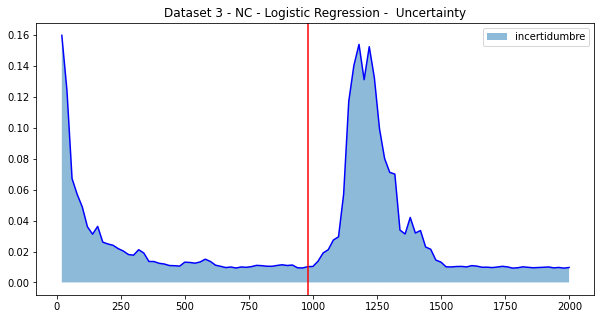

In [14]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset3, model = LogisticRegression())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 3 - NC - Logistic Regression - ', 'Dataset 3 - NC - Logistic Regression - ','Dataset 3 - NC - Logistic Regression - '])
 

##### Decision Tree Classifier

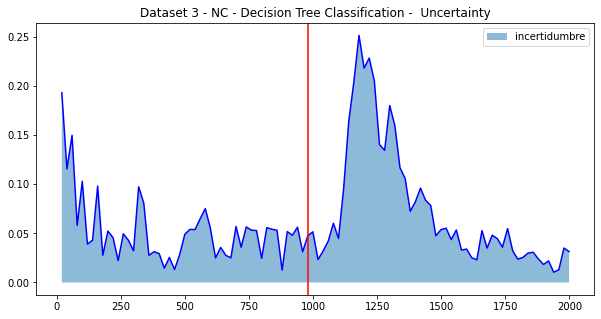

In [15]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset3, model = DecisionTreeClassifier())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 3 - NC - Decision Tree Classification - ', 'Dataset 3 - NC - Decision Tree Classification - ', 'Dataset 3 - NC - Decision Tree Classification - '])
 

#### Dataset 4

##### Logistic Regression


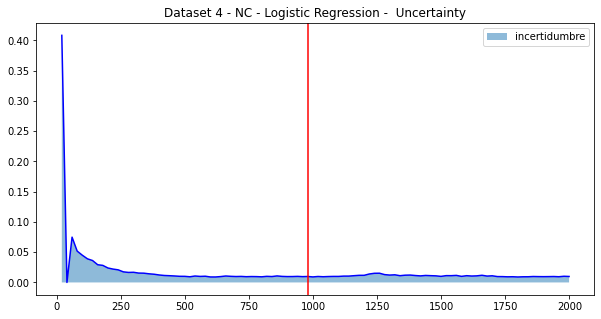

In [16]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset4, model = LogisticRegression())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 4 - NC - Logistic Regression - ', 'Dataset 4 - NC - Logistic Regression - ','Dataset 4 - NC - Logistic Regression - '])
 

##### Decision Tree Classifier

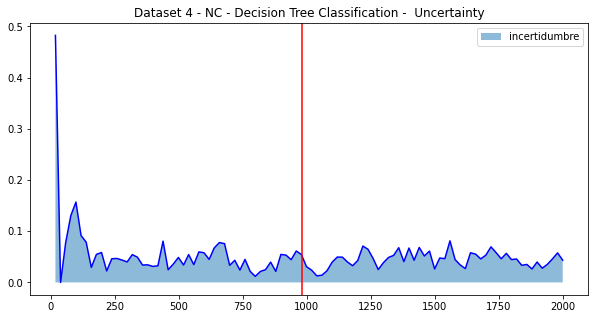

In [17]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset4, model = DecisionTreeClassifier())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 4 - NC - Decision Tree Classification - ', 'Dataset 4 - NC - Decision Tree Classification - ', 'Dataset 4 - NC - Decision Tree Classification - '])
 

#### Dataset 5

##### Logistic Regression


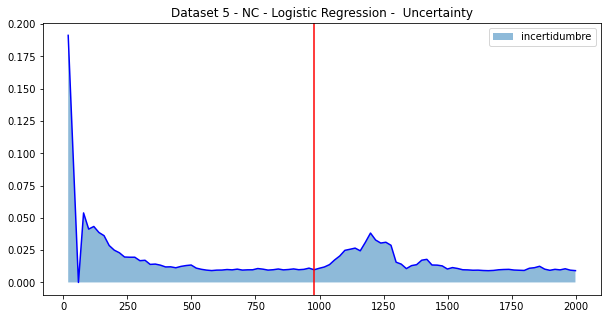

In [18]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset5, model = LogisticRegression())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 5 - NC - Logistic Regression - ', 'Dataset 5 - NC - Logistic Regression - ','Dataset 5 - NC - Logistic Regression - '])
 

##### Decision Tree Classifier

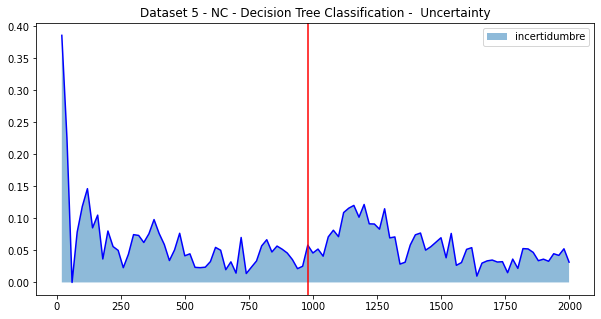

In [19]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset5, model = DecisionTreeClassifier())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 5 - NC - Decision Tree Classification - ', 'Dataset 5 - NC - Decision Tree Classification - ', 'Dataset 5 - NC - Decision Tree Classification - '])
 

#### Dataset 6

##### Logistic Regression


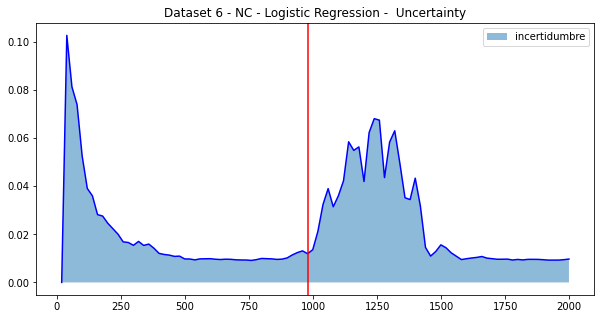

In [20]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset6, model = LogisticRegression())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 6 - NC - Logistic Regression - ', 'Dataset 6 - NC - Logistic Regression - ','Dataset 6 - NC - Logistic Regression - '])
 

##### Decision Tree Classifier

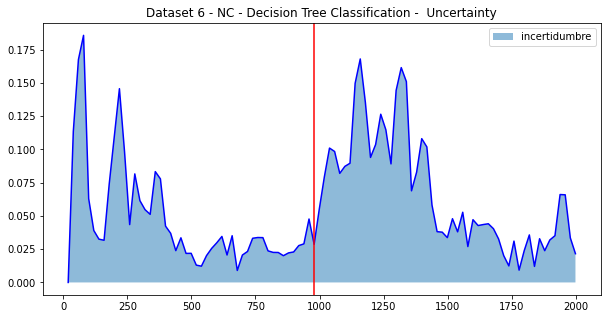

In [21]:
model, index_to_split = getUncertaintyByNCOnlineClassifier(dataset6, model = DecisionTreeClassifier())
showUncertaintyClassifier(model, drifts=[1000-index_to_split], titles=['Dataset 6 - NC - Decision Tree Classification - ', 'Dataset 6 - NC - Decision Tree Classification - ', 'Dataset 6 - NC - Decision Tree Classification - '])
 

### Cálculo de incertidumbre por Bootstrap


#### Implementación

In [22]:

def fit_model(X_train, X_test, y_train, y_test):
  model = SGDClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return model, accuracy

def getUncertaintyByBootstrap(dataset):
  accuracy_list = []
  for i in range(60):
    length = int(round(len(dataset.index)*0.8))
    X_train, X_test, y_train, y_test = dataset[['x','y']].head(length), dataset[['x','y']].tail(-length),dataset['target'].head(length), dataset['target'].tail(-length)
    model, accuracy = fit_model(X_train, X_test, y_train, y_test)
    accuracy_list.append(accuracy)
  accuracy_mean = np.mean(accuracy_list)
  accuracy_std = np.std(accuracy_list)
  return {'uncert95': [accuracy_mean + 1.96 * accuracy_std], 'uncert05': [accuracy_mean - 1.96*accuracy_std], 'n': dataset['n'].tolist()}

def getUncertaintyByBootstrapOnline(dataset):
  count = 80
  dataframes = []
  index_to_split = len(dataset) // count
  start = 0
  end = index_to_split
  for split in range(count):
    temporary_df = dataset.iloc[max(0, start-10*index_to_split):end, :]
    dataframes.append(temporary_df)
    start += index_to_split
    end += index_to_split
    

  data = list(map(lambda d: getUncertaintyByBootstrap(d), dataframes))
  data = list(map(lambda d: {'uncert95': [np.mean(d['uncert95'])], 'uncert05': [np.mean(d['uncert05'])], 'n': [d['n'][-1]] }, data))
  single_data = reduce(mergeDict, data)
  df = pd.DataFrame(single_data)
  return df, index_to_split

#### Dataset 1

##### SGD Classifier

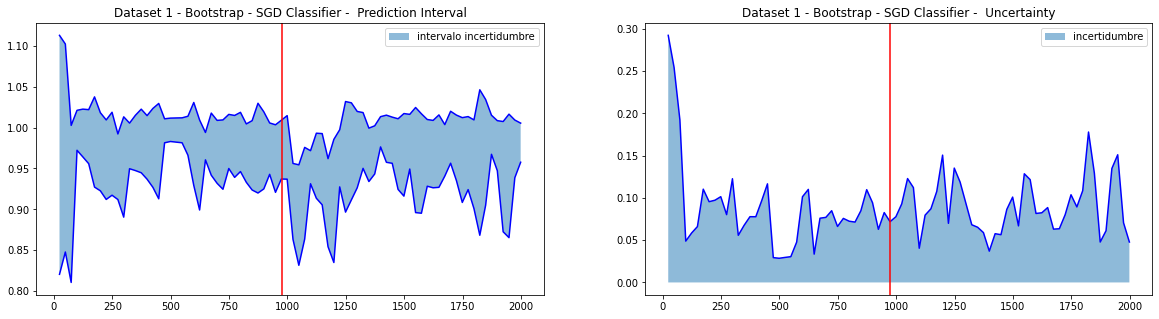

In [23]:
model, index_to_split = getUncertaintyByBootstrapOnline(dataset1)
showUncertaintyClassifier2(model, drifts=[1000-index_to_split], titles=['Dataset 1 - Bootstrap - SGD Classifier - ', 'Dataset 1 - Bootstrap - SGD Classifier - ','Dataset 1 - Bootstrap - SGD Classifier - '])
  

#### Dataset 2

##### SGD Classifier

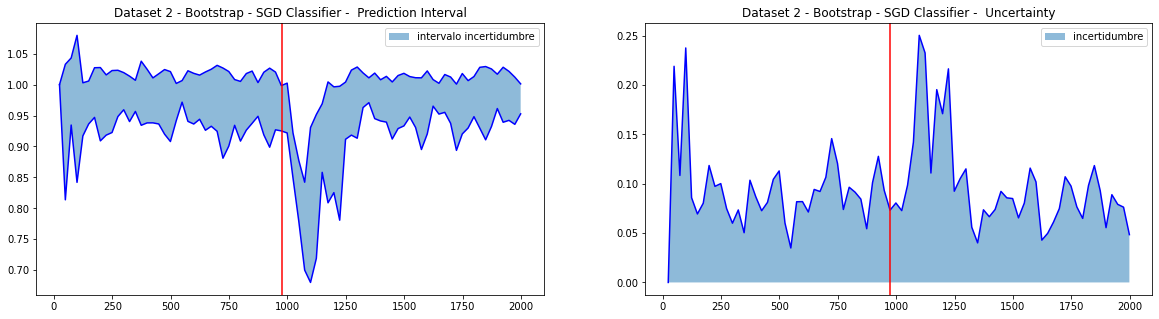

In [24]:
model, index_to_split = getUncertaintyByBootstrapOnline(dataset2)
showUncertaintyClassifier2(model, drifts=[1000-index_to_split], titles=['Dataset 2 - Bootstrap - SGD Classifier - ', 'Dataset 2 - Bootstrap - SGD Classifier - ','Dataset 2 - Bootstrap - SGD Classifier - '])
 

#### Dataset 3

##### SGD Classifier

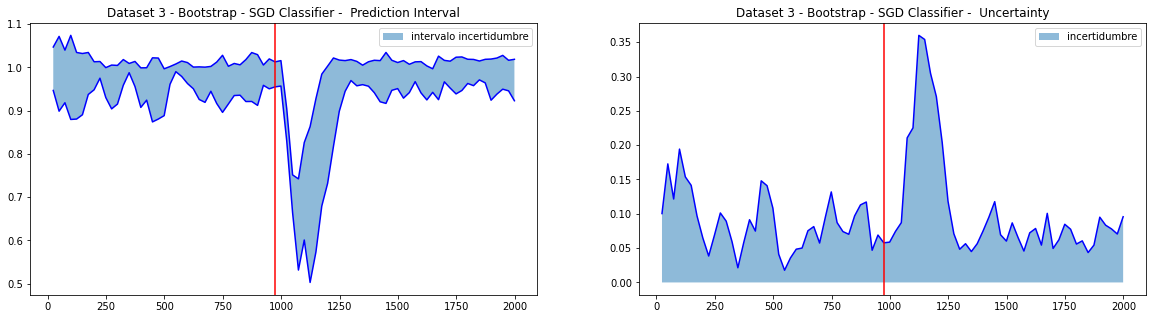

In [25]:
model, index_to_split = getUncertaintyByBootstrapOnline(dataset3)
showUncertaintyClassifier2(model, drifts=[1000-index_to_split], titles=['Dataset 3 - Bootstrap -SGD Classifier - ', 'Dataset 3 - Bootstrap - SGD Classifier - ','Dataset 3 - Bootstrap - SGD Classifier - '])
 

#### Dataset 4

##### SGD Classifier

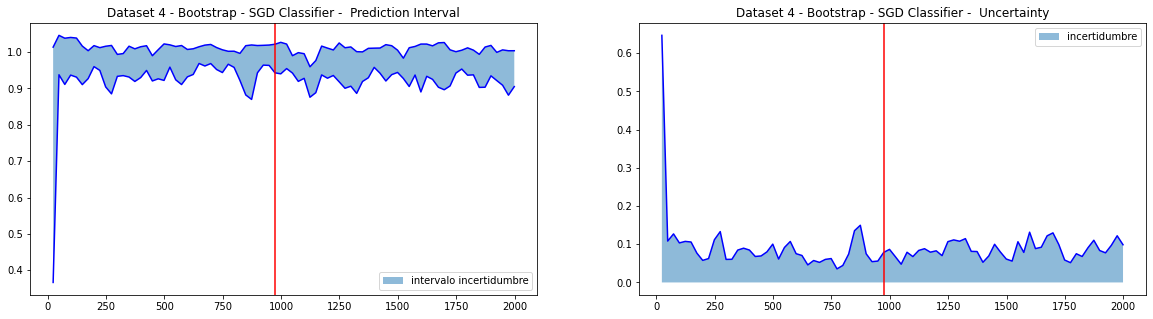

In [26]:
model, index_to_split = getUncertaintyByBootstrapOnline(dataset4)
showUncertaintyClassifier2(model, drifts=[1000-index_to_split], titles=['Dataset 4 - Bootstrap - SGD Classifier - ', 'Dataset 4 - Bootstrap - SGD Classifier - ','Dataset 4 - Bootstrap - SGD Classifier - '])
 

#### Dataset 5

##### SGD Classifier

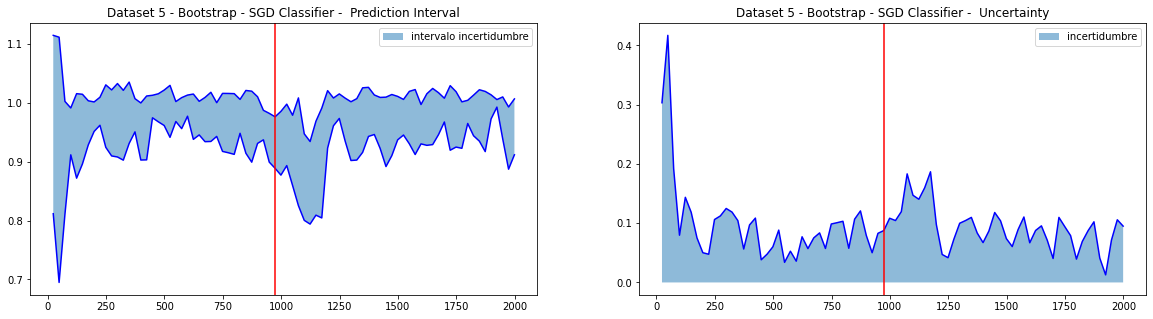

In [27]:
model, index_to_split = getUncertaintyByBootstrapOnline(dataset5)
showUncertaintyClassifier2(model, drifts=[1000-index_to_split], titles=['Dataset 5 - Bootstrap - SGD Classifier - ', 'Dataset 5 - Bootstrap - SGD Classifier - ','Dataset 5 - Bootstrap - SGD Classifier - '])
 

#### Dataset 6

##### SGD Classifier

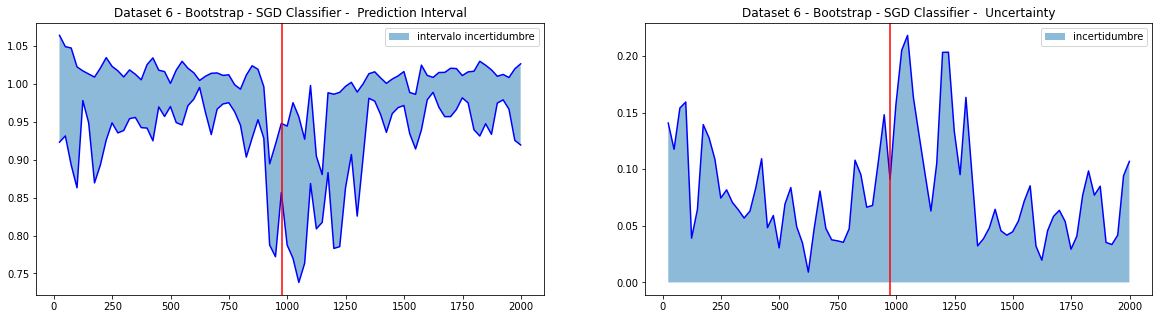

In [28]:
model, index_to_split = getUncertaintyByBootstrapOnline(dataset6)
showUncertaintyClassifier2(model, drifts=[1000-index_to_split], titles=['Dataset 6 - Bootstrap - SGD Classifier - ', 'Dataset 6 - Bootstrap - SGD Classifier - ','Dataset 6 - Bootstrap - SGD Classifier - '])
 